<a href="https://colab.research.google.com/github/kripperda/MLA_KMR/blob/main/FinalProject_Regression_KMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning Final Assignment


---

Kory Ripperda

Problem 1 - Regression

---

Chemical analysis to determine the origin of wines

Standard Imports

In [55]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Scikit-learn modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer # For handling different feature types
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Configure plots
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

print("Libraries Loaded.")

Libraries Loaded.


Import Dataset from UCI

In [56]:
# Load the Red Wine Quality dataset directly from the UCI repository URL
# Note: The data is semicolon-separated
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

try:
    df = pd.read_csv(data_url, sep=';')
    print("Wine Quality dataset loaded successfully.")
    print(f"Shape of the dataset: {df.shape}")

except Exception as e:
    print(f"An error occurred during data loading: {e}")
    # Exit or handle error appropriately if data loading fails
    df = None # Ensure df is None if loading failed

Wine Quality dataset loaded successfully.
Shape of the dataset: (1599, 12)


Statistics and Visual Exploration


First 5 rows:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2    

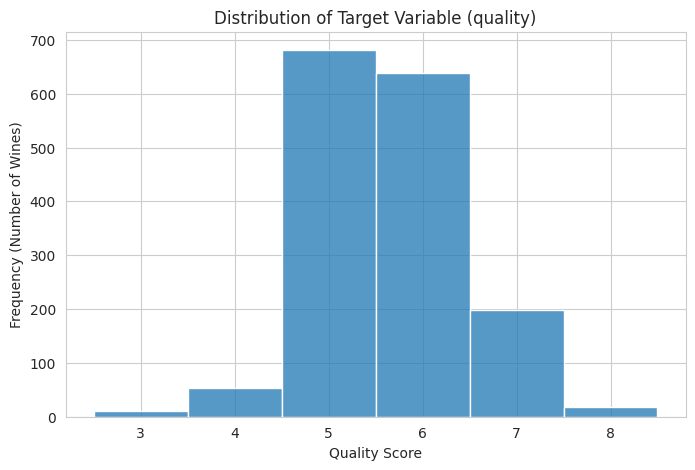


Features for analysis: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Distributions of Features:


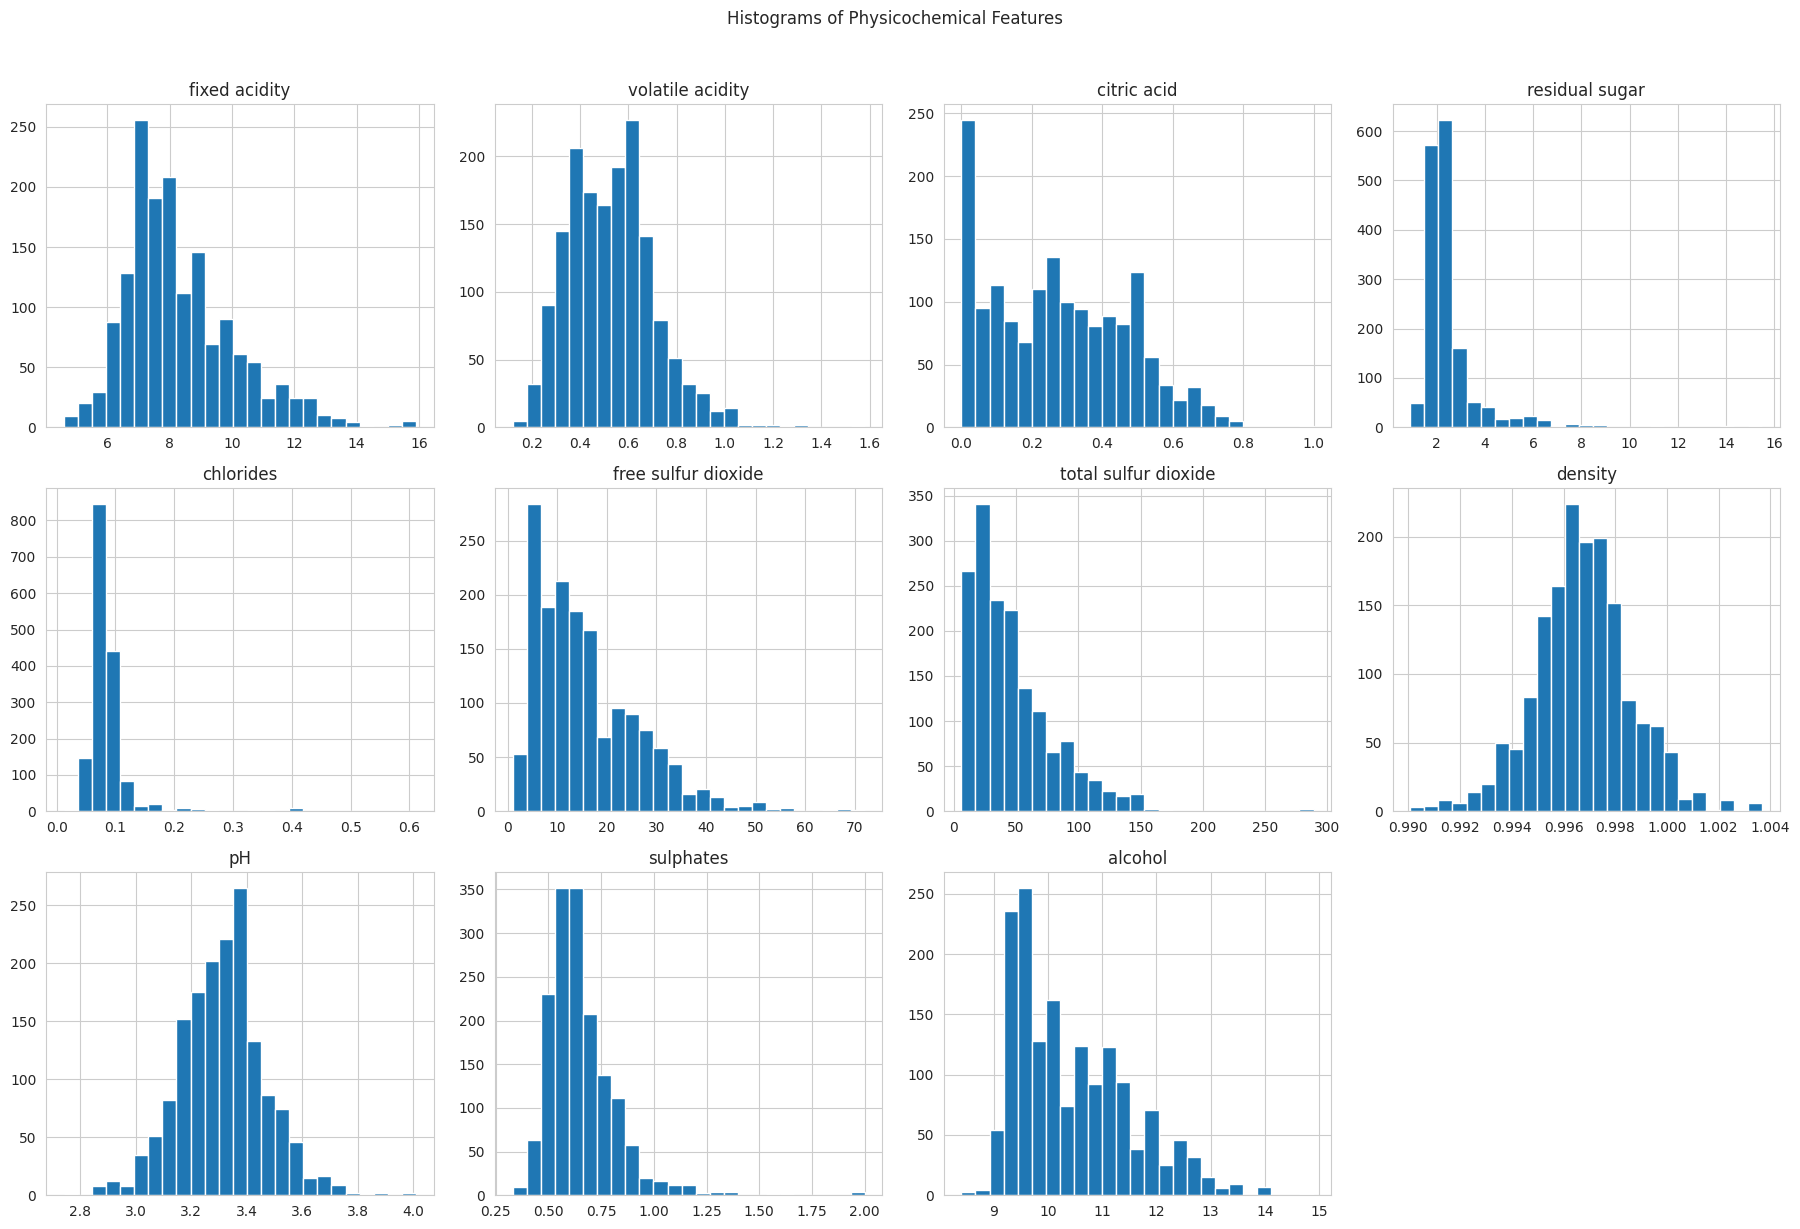


Relationship between Features and Target (Quality):


<ipython-input-57-53bb368d8d03>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, ax=axes[i], palette="vlag")
<ipython-input-57-53bb368d8d03>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, ax=axes[i], palette="vlag")
<ipython-input-57-53bb368d8d03>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, ax=axes[i], palette="vlag")
<ipython-input-57-53bb368d8d03>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remove

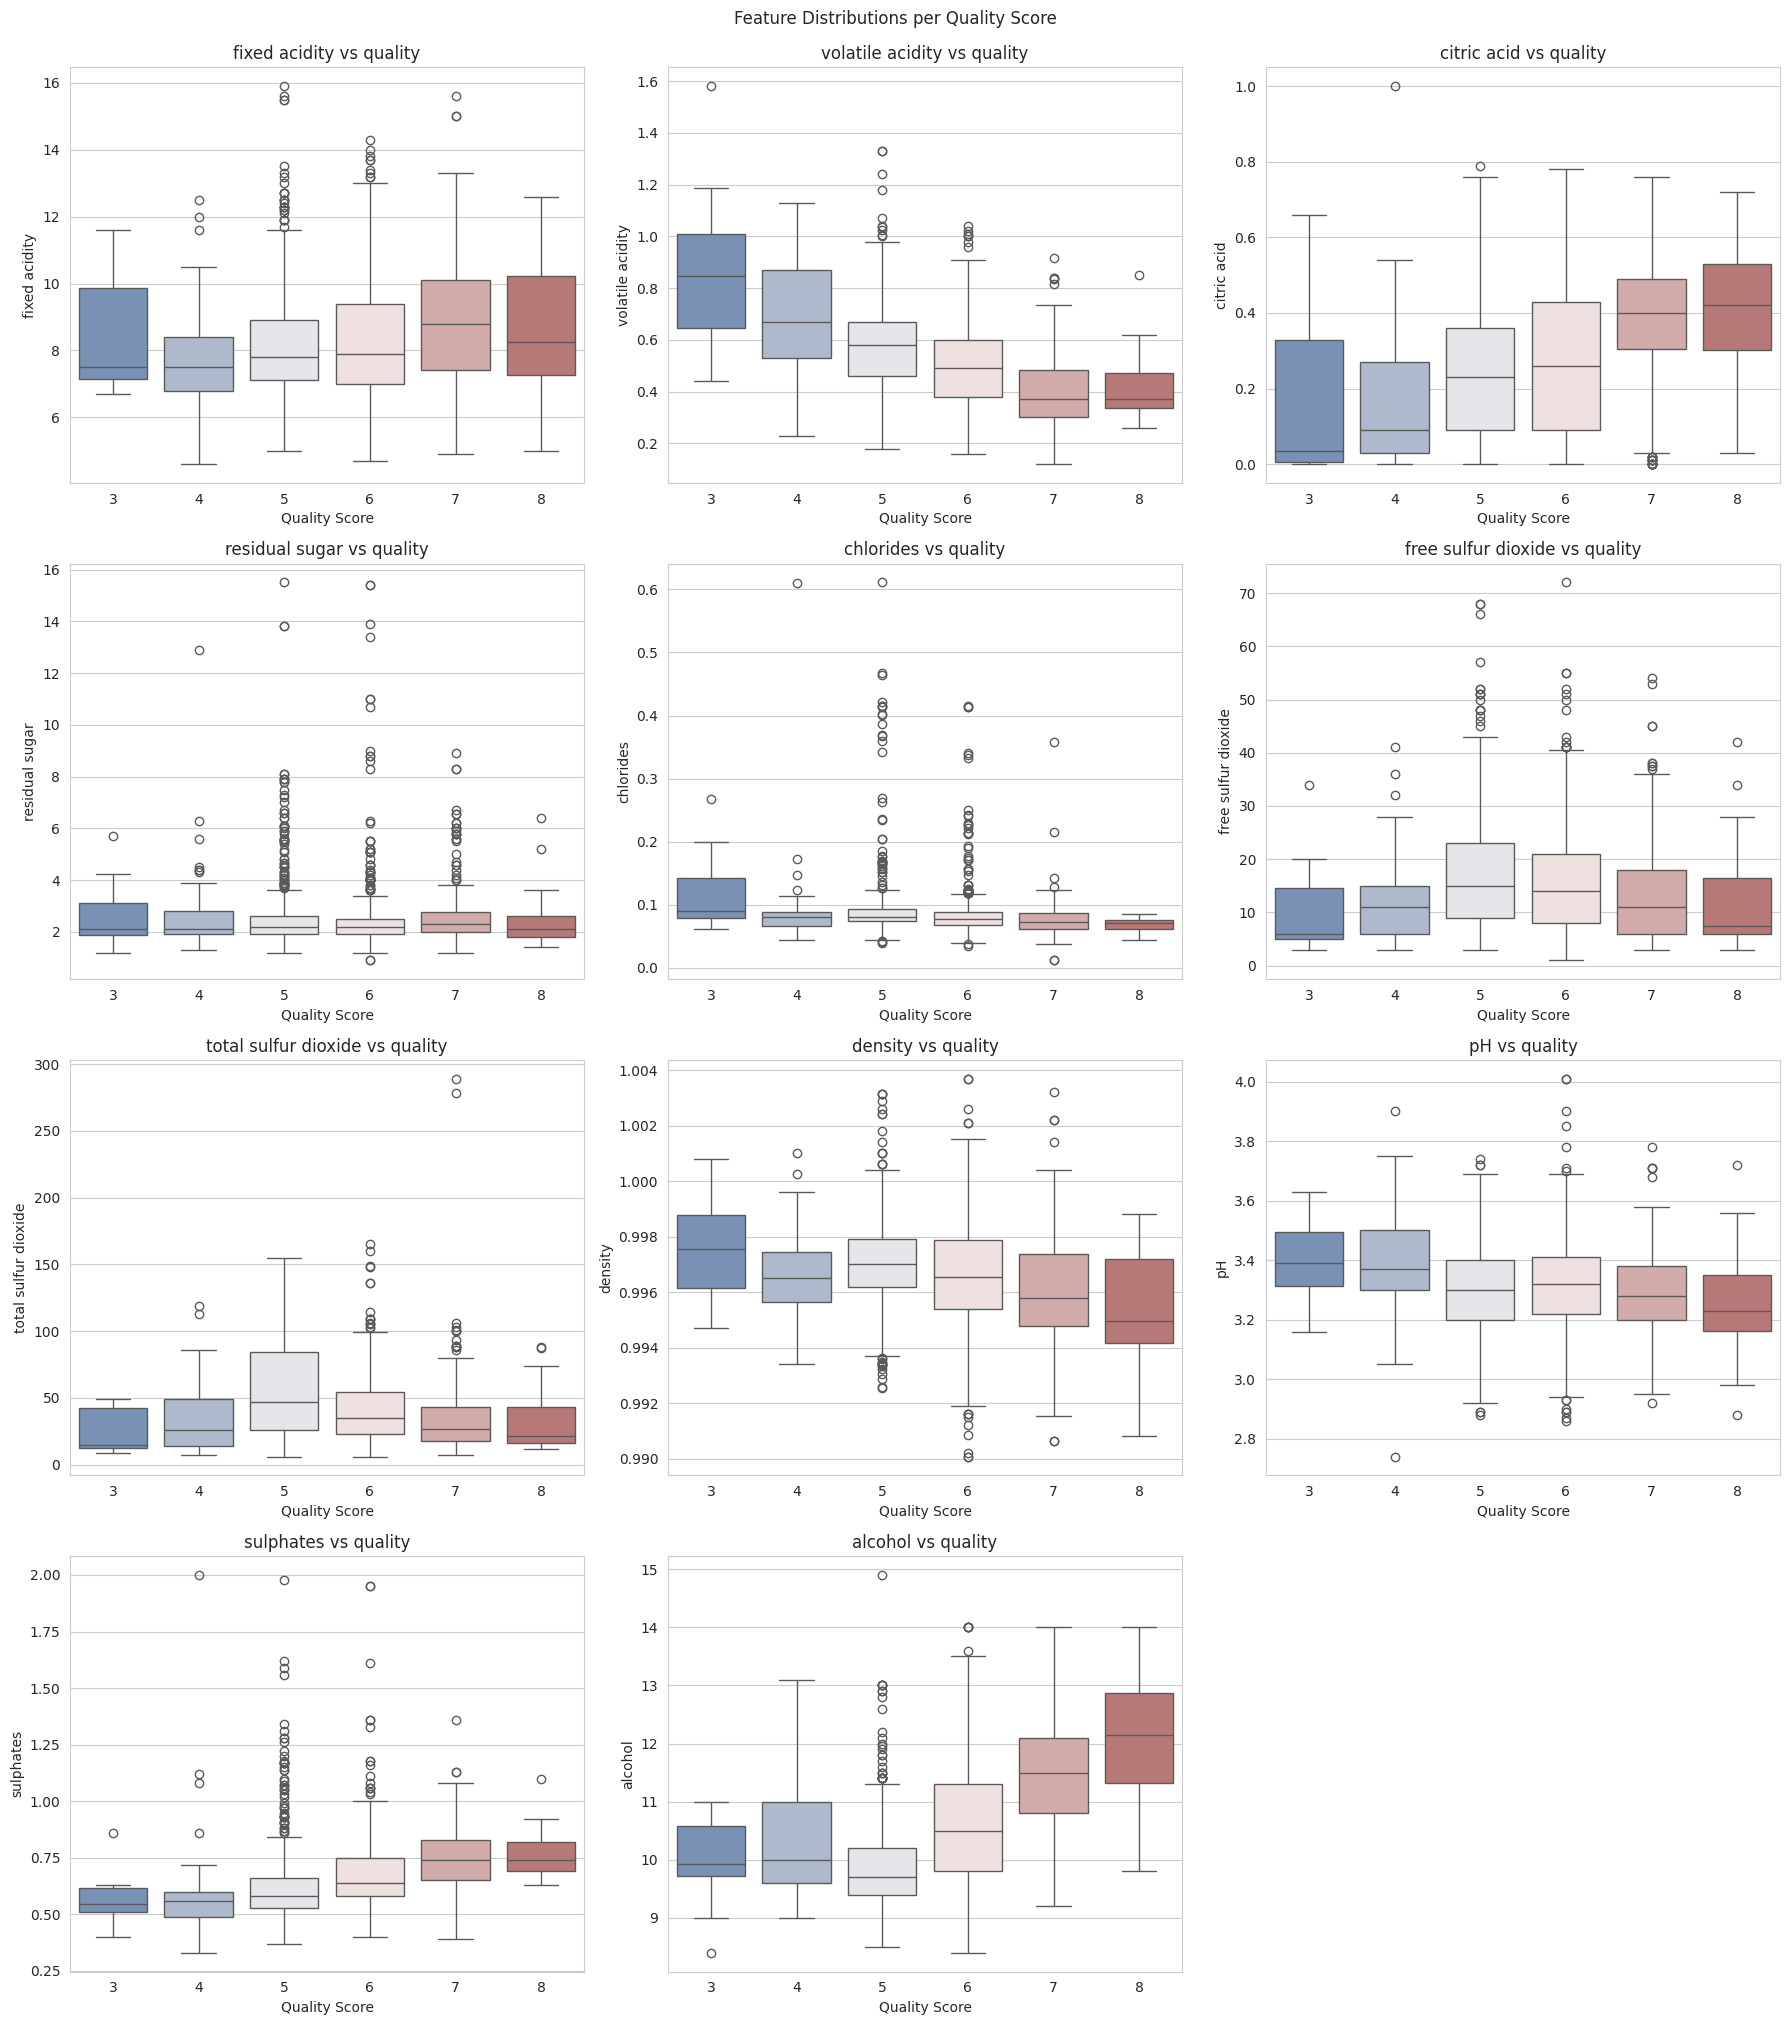


Correlation Matrix Heatmap:


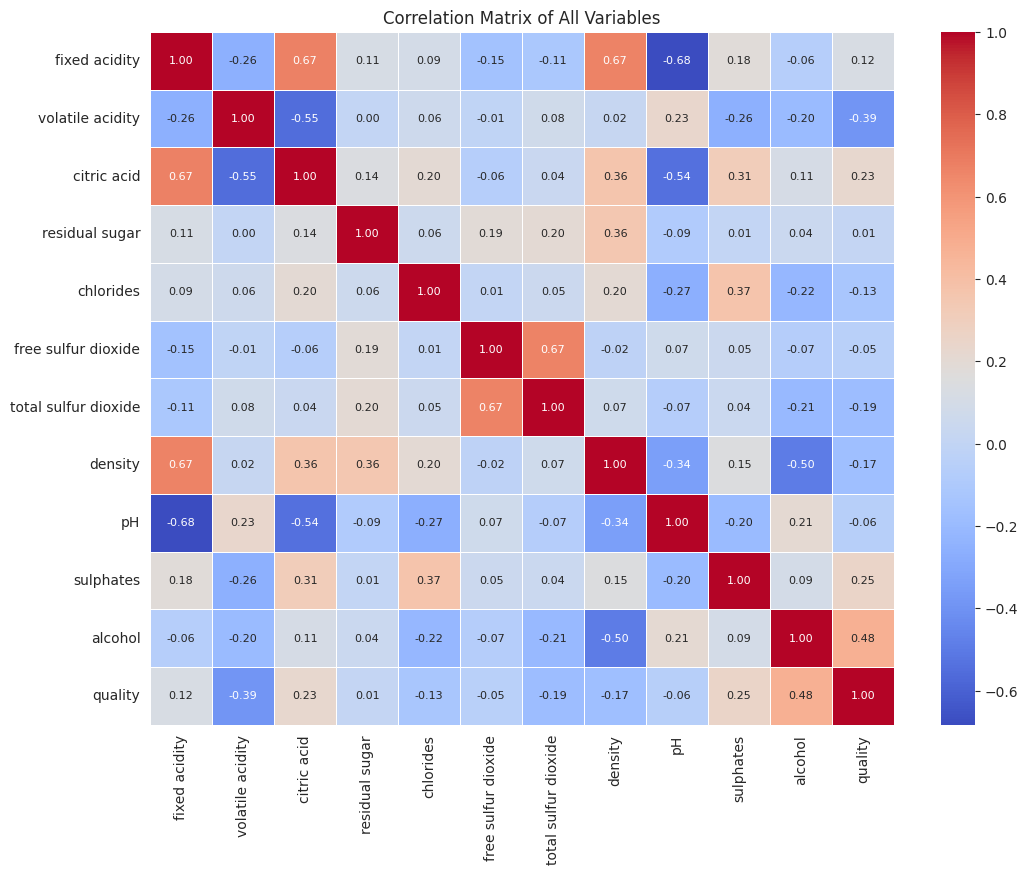

In [57]:
if df is not None: # Proceed only if data loading was successful
    #Initial Inspection
    print("\nFirst 5 rows:")
    print(df.head())

    print("\nDataset Info:")
    df.info()
    # Observation: All columns are numerical (int64 or float64), and there are no missing values.

    #Summary Statistics
    print("\nSummary Statistics:")
    print(df.describe())

    #Missing Values Check (already confirmed by info(), but good practice)
    print("\nMissing Values per Column:")
    print(df.isnull().sum())
    # Observation: Confirmed no missing values.

    #Target Variable Analysis ('quality')
    target_col = 'quality'
    print(f"\nAnalysis of Target Variable: '{target_col}'")

    print("\nValue Counts for Quality:")
    print(df[target_col].value_counts().sort_index())

    plt.figure(figsize=(8, 5))
    sns.histplot(df[target_col], bins=len(df[target_col].unique()), kde=False, discrete=True)
    plt.title(f'Distribution of Target Variable ({target_col})')
    plt.xlabel('Quality Score')
    plt.ylabel('Frequency (Number of Wines)')
    plt.xticks(sorted(df[target_col].unique())) # Ensure ticks match the discrete scores
    plt.show()
    # Observation: Quality scores are discrete (3-8). Most wines are rated 5 or 6. Fewer wines have very low or high scores.

    #Feature Analysis & Visualization

    # Identify numerical features (all except target)
    features = df.drop(target_col, axis=1).columns.tolist()
    print(f"\nFeatures for analysis: {features}")

    # Histograms for numerical features
    print("\nDistributions of Features:")
    df[features].hist(bins=25, figsize=(18, 12), layout=(-1, 4))
    plt.suptitle('Histograms of Physicochemical Features', y=1.02)
    plt.tight_layout()
    plt.show()
    # Observation: Features have varying distributions. Some are roughly normal (e.g., pH, density), while others are skewed (e.g., residual sugar, chlorides, sulphates, alcohol). Scaling will be important.

    # Relationship between Features and Target
    # Using boxplots as target is discrete/ordinal
    print("\nRelationship between Features and Target (Quality):")
    num_features = len(features)
    num_cols = 3
    num_rows = (num_features + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(features):
        sns.boxplot(x=target_col, y=col, data=df, ax=axes[i], palette="vlag")
        axes[i].set_title(f'{col} vs {target_col}')
        axes[i].set_xlabel('Quality Score')
        axes[i].set_ylabel(col)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle('Feature Distributions per Quality Score', y=1.01)
    plt.show()
    # Observations:
    # - Alcohol content generally increases with higher quality scores.
    # - Volatile acidity tends to decrease with higher quality.
    # - Sulphates and Citric acid show some positive trend with quality.
    # - Other features show less clear trends across quality scores via boxplots alone.

    # Correlation Matrix Heatmap
    print("\nCorrelation Matrix Heatmap:")
    plt.figure(figsize=(12, 9))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
    plt.title('Correlation Matrix of All Variables')
    plt.show()
    # Observations:
    # - 'alcohol' has the highest positive correlation with 'quality' (0.48).
    # - 'volatile acidity' has the strongest negative correlation (-0.39).
    # - 'sulphates' (0.25) and 'citric acid' (0.23) show moderate positive correlation.
    # - Some features are correlated with each other (e.g., fixed acidity and citric acid, fixed acidity and density).

else:
    print("EDA skipped because the dataframe 'df' could not be loaded.")


Split Data into Train/Test

In [58]:
if df is not None:
    #Define Features (X) and Target (y)
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")

    #Split Data into Training and Testing Sets
    # Using 80% for training, 20% for testing. random_state ensures reproducibility.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"Training set size: {X_train.shape[0]} samples ({len(X_train)/len(df)*100:.1f}%)")
    print(f"Testing set size: {X_test.shape[0]} samples ({len(X_test)/len(df)*100:.1f}%)")

    #Define Preprocessing Steps (Scaling)
    scaler = StandardScaler()
    print("\nPreprocessor defined: StandardScaler (to be applied via pipeline)")

else:
    print("Preprocessing skipped because 'df' is not available.")

Features shape: (1599, 11)
Target shape: (1599,)
Training set size: 1279 samples (80.0%)
Testing set size: 320 samples (20.0%)

Preprocessor defined: StandardScaler (to be applied via pipeline)


Build the Pipeline - Regression

In [59]:
if 'X_train' in locals(): # Check if data splitting was successful

    #Linear Regression Model with Pipeline
    print("\nBuilding Linear Regression Pipeline...")
    lr_pipeline = Pipeline(steps=[
        ('scaler', scaler),             # Apply StandardScaler
        ('regressor', LinearRegression()) # Linear Regression model
    ])


Building Linear Regression Pipeline...


Execute the Model - Regression

In [60]:
  # Train the Linear Regression model
  lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

Build the Pipeline - Support Vector Machine

In [61]:
if 'X_train' in locals(): # Check if data splitting was successful

    #Support Vector Regression (SVR) Model with Pipeline
    print("\nBuilding Support Vector Regression (SVR) Pipeline...")
    # Use default SVR parameters initially
    svr_pipeline = Pipeline(steps=[
        ('scaler', scaler),         # Apply StandardScaler (Crucial for SVR)
        ('regressor', SVR())
    ])

else:
    print("Model building skipped because training data is not available.")


Building Support Vector Regression (SVR) Pipeline...


Execute the Model - Support Vector Machine

In [62]:
    # Train the SVR model
    svr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('regressor', SVR())])

Build the Pipeline - GridSearch

In [63]:
    # SVR Model with GridSearchCV Pipeline
    print("\nBuilding SVR Pipeline with GridSearchCV...")

    # Define the parameter grid for SVR
    param_grid_svr = {
        'regressor__C': [0.1, 1, 10, 50, 100],         # Regularization strength
        'regressor__gamma': ['scale', 'auto', 0.1, 1], # Kernel coefficient for 'rbf'
        'regressor__kernel': ['rbf'],                  # Focusing on RBF kernel as it's common/powerful
        'regressor__epsilon': [0.1, 0.2, 0.5]          # Epsilon tube width
    }

    # Create the GridSearchCV object
    # Scoring: 'neg_mean_squared_error' (GridSearchCV maximizes, so we use negative MSE)
    # cv=5: 5-fold cross-validation
    svr_grid_search = GridSearchCV(svr_pipeline, # Use the base SVR pipeline
                                   param_grid_svr,
                                   cv=5,
                                   scoring='neg_mean_squared_error',
                                   n_jobs=-1, # Use all available CPU cores
                                   verbose=1) # Show progress


Building SVR Pipeline with GridSearchCV...


Execute the Model - GridSearch

In [64]:
    # Fit GridSearchCV to the training data
    svr_grid_search.fit(X_train, y_train)

    # Get the best parameters and the best estimator (pipeline)
    print(f"\nBest SVR parameters found by GridSearchCV: {svr_grid_search.best_params_}")
    best_svr_pipeline = svr_grid_search.best_estimator_
    print("GridSearchCV for SVR Complete. Best estimator stored as 'best_svr_pipeline'.")

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best SVR parameters found by GridSearchCV: {'regressor__C': 1, 'regressor__epsilon': 0.2, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}
GridSearchCV for SVR Complete. Best estimator stored as 'best_svr_pipeline'.


Evaluate the Model


Calculating RMSE...
Linear Regression:
  RMSE Train: 0.6513
  RMSE Test:  0.6245
SVR (Default):
  RMSE Train: 0.5550
  RMSE Test:  0.5928
SVR (GridSearchCV):
  RMSE Train: 0.5518
  RMSE Test:  0.5876

RMSE Summary:
                    RMSE_Train  RMSE_Test
Linear Regression     0.651300   0.624520
SVR (Default)         0.554984   0.592768
SVR (GridSearchCV)    0.551835   0.587631

Target variable 'quality' standard deviation (for context): 0.8076


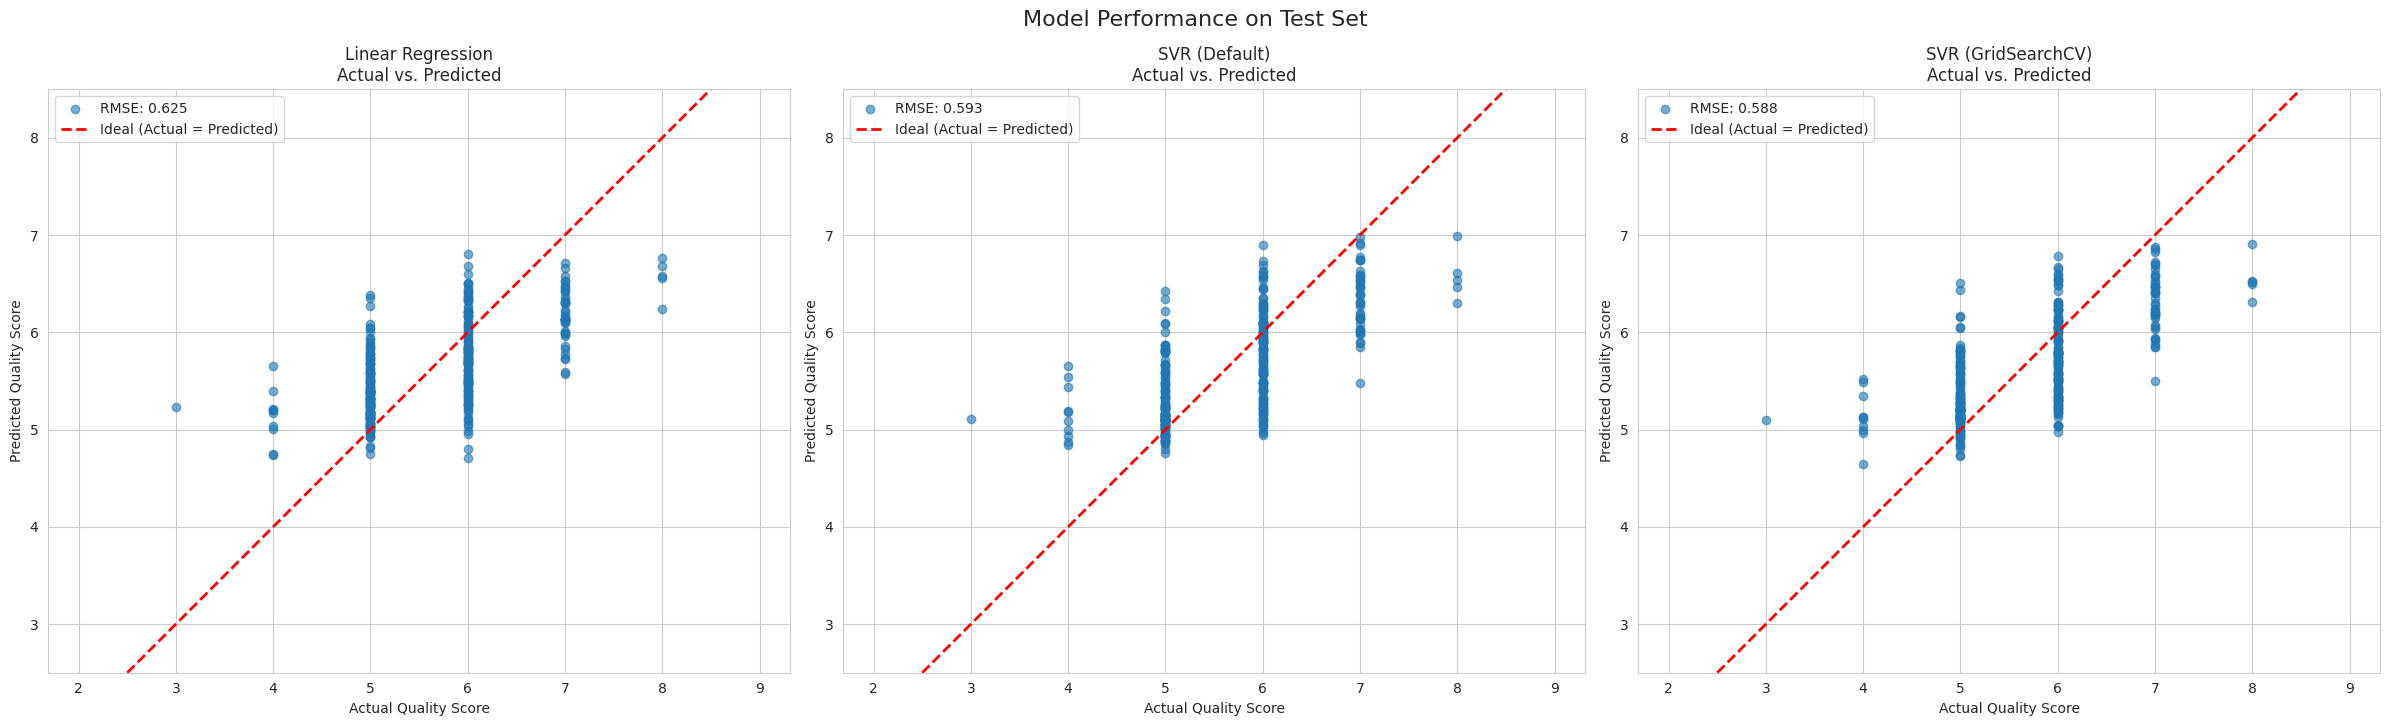

In [65]:
if 'lr_pipeline' in locals() and 'svr_pipeline' in locals() and 'best_svr_pipeline' in locals():

    models = {
        "Linear Regression": lr_pipeline,
        "SVR (Default)": svr_pipeline,
        "SVR (GridSearchCV)": best_svr_pipeline
    }

    results = {}

    #Calculate RMSE for Train and Test sets
    print("\nCalculating RMSE...")
    for name, model in models.items():
        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # RMSE calculation (sqrt of MSE)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        results[name] = {'RMSE_Train': rmse_train, 'RMSE_Test': rmse_test}
        print(f"{name}:")
        print(f"  RMSE Train: {rmse_train:.4f}")
        print(f"  RMSE Test:  {rmse_test:.4f}")

    # Store results in a DataFrame for easy comparison
    results_df = pd.DataFrame(results).T # Transpose for better readability
    print("\nRMSE Summary:")
    print(results_df)
    print(f"\nTarget variable 'quality' standard deviation (for context): {y.std():.4f}")
    # Comparing RMSE to the standard deviation of the target gives context to the error magnitude.

    num_models = len(models)
    plt.figure(figsize=(8 * num_models, 7)) # Adjust figure size

    plot_counter = 1
    for name, model in models.items():
        plt.subplot(1, num_models, plot_counter)
        y_test_pred = model.predict(X_test)

        # Determine plot limits based on actual and predicted values
        min_val = min(y_test.min(), y_test_pred.min()) - 0.5 # Add buffer
        max_val = max(y_test.max(), y_test_pred.max()) + 0.5 # Add buffer

        plt.scatter(y_test, y_test_pred, alpha=0.6, label=f'RMSE: {results[name]["RMSE_Test"]:.3f}')
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ideal (Actual = Predicted)') # Diagonal line
        plt.xlabel("Actual Quality Score")
        plt.ylabel("Predicted Quality Score")
        plt.title(f"{name}\nActual vs. Predicted")
        plt.legend()
        plt.grid(True)
        plt.axis('equal') # Ensure x and y axes have the same scale
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        # Optionally add discrete ticks if helpful
        # plt.xticks(np.arange(int(min_val)+1, int(max_val)))
        # plt.yticks(np.arange(int(min_val)+1, int(max_val)))

        plot_counter += 1

    plt.tight_layout()
    plt.suptitle("Model Performance on Test Set", y = 1.03, fontsize=16)
    plt.show()

else:
    print("Model evaluation skipped because models were not trained.")

For regression tasks like predicting wine quality score, ROC curves and Precision-Recall curves are NOT suitable.
Those curves are designed for evaluating binary (or sometimes multi-class) classification models, assessing performance across different decision thresholds.
Instead, we use scatter plots of Actual vs. Predicted values on the TEST set.
 - This plot directly visualizes the accuracy of the predictions.
 - Points clustered closely around the diagonal line (y=x) indicate a good model where predicted values match actual values.
 - The spread of points shows the magnitude and distribution of errors.

This is the standard and most informative plot for evaluating regression model performance visually.

Conclusion

1. The model performing best on the test set, based on the lowest Root Mean Squared Error (RMSE), is 'SVR (GridSearchCV)' with an RMSE of 0.5876.
   - Linear Regression Test RMSE: 0.6245
   - SVR (Default) Test RMSE:     0.5928
   - SVR (Tuned) Test RMSE:     0.5876
   (For context, the standard deviation of the target variable 'quality' is 0.8076. An RMSE lower than this indicates the model has some predictive power.)

2. GridSearchCV for SVR improved performance compared to the default SVR.
 - The Test RMSE decreased from 0.5928 to 0.5876, an improvement of 0.0051 (0.87%).
 - The best parameters found were: {'regressor__C': 1, 'regressor__epsilon': 0.2, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}.
   - This suggests that hyperparameter tuning was beneficial for the SVR model on this dataset.

3. Assessing Overfitting/Underfitting (comparing Train vs. Test RMSE):
   - Linear Regression: Train RMSE=0.6513, Test RMSE=0.6245 (Difference: -0.0268) - Minimal difference
   - SVR (Default): Train RMSE=0.5550, Test RMSE=0.5928 (Difference: 0.0378) - Minimal difference
   - SVR (GridSearchCV): Train RMSE=0.5518, Test RMSE=0.5876 (Difference: 0.0358) - Minimal difference
   (A significantly lower Train RMSE compared to Test RMSE can indicate overfitting.)

4. Insights from Analysis:
   - EDA indicated 'alcohol', 'volatile acidity', 'sulphates', and 'citric acid' were the features most correlated with 'quality', suggesting they are important predictors, which the models likely leveraged.
   - The Actual vs. Predicted plots visually confirm the RMSE results. The points for the best model ('SVR (GridSearchCV)') appear slightly more clustered around the ideal diagonal line compared to the other models.
   - However, all models show considerable scatter, indicating that predicting the exact quality score is challenging with these features alone. Predictions tend to be clustered around the mean quality scores (5-6), and the models struggle more at predicting the rarer low (3, 4) and high (8) quality wines.

5. Limitations:
   - The 'quality' score is subjective and discrete/ordinal, but was treated as continuous for regression. This might limit model accuracy, as the underlying scale isn't truly continuous.
   - The dataset has an imbalanced distribution of quality scores, with fewer examples for low and high-quality wines, making it harder for models to learn patterns for these scores.
   - Linear Regression assumes linear relationships, which might not hold for all features.
   - The evaluation relies on a single train/test split. Cross-validation on the entire dataset could provide a more robust estimate of generalization performance.

**6. Recommendation:**
Based on the lowest Test RMSE (0.5876), the **SVR model tuned with GridSearchCV ('SVR (GridSearchCV)')** is recommended for predicting red wine quality from the given features.
While the improvement over Linear Regression and default SVR was noticeable, the overall predictive accuracy still has limitations, likely due to the nature of the target variable and potential lack of linear features unable to be fully captured.
Future work could involve exploring non-linear models (like Random Forest Regressor or Gradient Boosting Regressor), feature engineering, or treating the problem as an ordinal classification task instead of regression.